In [16]:

%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import datetime
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geo_utils import (
    radius_search,
    k_nearest_search,
    get_geometry_neighbors,
)
from stat_utils import bootstrap_statistic, jitter, PositiveStat
from schuster import Schuster
from data import MidAtlanticRidge, GIA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
font = {"size": 8}
mpl.rc("font", **font)
mpl.rc("figure", dpi=100)

## TODO
- Filter events by proximity to focal mechasnism
- Filter the seasonal signal based on predicted contraction/extension
- Make a schuster walk.


## Analysis of seismicity along the North Atlantic spreading ridge

### Overview

The analysis roughly follows the these steps:

* Get shapefile for spreading ridge
* Upsample at desired point spacing
* get corresponding earthquake catalog
* get k-nearest earthquakes at each point along spreading ridge
* calculate statistics:
  * b-value (b+)
  * a-value
* get the modelled strai
* get spatially averaged strain along the same section
* correlate statistics to strain rate

Subsequent analysis:
* remove trends associated to spreading rate and faulting style 
* clustrered vs. declustered
* record major geological features along the spreading ridge (e.g. iceland, major earthquakes, etc)


### Useful literature

Note that an analysis was loosely inspired (although it has since diverged significantly) by the workflow in:

*A unified perspective of seismicity and fault coupling along the San Andreas Fault*

https://www.science.org/doi/full/10.1126/sciadv.abk1167?fbclid=IwAR2HdRzrYRcHJaV3LrciFyn0m-9RpNZ20oOmbagbXI176iIFLSaHxj3LiUk&intcmp=trendmd-adv&adobe_mc=MCMID%3D22100252661862915997832685880766884763%7CMCORGID%3D242B6472541199F70A4C98A6%2540AdobeOrg%7CTS%3D1652659200

In a quick literature review it seems like some of this analysis has already been done:

*Ice melting and earthquake suppression in Greenland*

https://www.sciencedirect.com/science/article/pii/S1873965214000681#bib3

Relavant litterature and resouces:

Here is a relatively detailed record of the seismic network in the polar region:

https://www.ngdc.noaa.gov/mgg/avetisov/CHAP1.htm

A catalog more or less complete to M4.5 in 1965!

Lynn R. Sykes; The seismicity of the Arctic. Bulletin of the Seismological Society of America 1965;; 55 (2): 501–518. doi: https://doi.org/10.1785/BSSA0550020501

Analysis of sesimicity along the entrie atlantic spreading ridge: 

Estimation of the Tapered Gutenberg-Richter Distribution Parameters for Catalogs with Variable Completeness: An Application to the Atlantic Ridge Seismicity

Appl. Sci. 2021, 11(24), 12166; https://doi.org/10.3390/app112412166


## Required Files and Metadata

In [18]:

data_dir = "data/"

plate_boundary_metadata = {
    "filename": data_dir + "plate_boundaries/PB2002_boundaries.shp",
    "boundary_names": ["NA-EU", "EU-NA"],
    "stepsize": 50000, # meters (the point spacing of the plate boundary)
}

earthquake_catalog_metadata = {
    "ISC": {
        "filename": data_dir + "global_M4.csv",
        "query":{
            "minimum_magnitude": 4.0,
            "starttime": "1960-01-01",
            "endtime": "2022-01-01",
            "reload":False,
        },
        "buffer_km": 100,
    },
    "mag_completeness":4.0, # change this to avoid re-downloading the catalog
}

earthquake_metadata = earthquake_catalog_metadata["ISC"]  # Option here

AVAILABLE_STRAIN_RATE_FILES = {
    "november22": "november_22/strain.mat",
    "febuary23_thick": "febuary_23/yearly_strain_rate_tensors_l90ump5lm3_smoothice.mat",
    "febuary23_thin": "febuary_23/yearly_strain_rate_tensors_l40um5_18lm3_smoothice.mat",
    "febuary23_2d": "febuary_23/yearly_strain_rate_tensors_l90ump5lm3_smoothice_2D_WDEG1.mat",   # only horizonatal stains are available,
    "april23_thin": "April23/Full Strain Tensors w Smoothing/yearly_strain_rate_tensors_l40um5_18lm3_smoothice_S.mat",
    "april23_thick": "April23/Full Strain Tensors w Smoothing/yearly_strain_rate_tensors_l90ump5lm3_smoothice_S.mat",
    "april23_long_term": "April23/Background Long Term GIA Strains/presentday_strain_rate_tensors_l90ump5lm3_ICE6G_S.mat",
}

GrGIA_strain_metadata = {
    "filename": data_dir + AVAILABLE_STRAIN_RATE_FILES["april23_thin"],
    "data_key": "strain_out", # unfortunately this is not consistent accross datasets.
    "data_config":{
        "starttime": 1993,
        "endtime": 2020,
        "number_of_times": 27,
        "latitude_range": [-90, 90],
        "number_of_latitudes": 510,
        "longitude_range": [-180, 180],
        "number_of_longitudes": 1022,
    },
    "strain_units": [1e-9, "s^{-1}"],  # scale, unit
    "strain_positive_convention": "compression",
    "longterm_filename": data_dir + AVAILABLE_STRAIN_RATE_FILES["april23_long_term"], 
}

crs = ccrs.NorthPolarStereo()

region_metadata = {
    "bounding_box": [-180, 55, 10, 90],
    "exclude_iceland":True,
    "iceland_bounds": [(-25, 52), (-25, 68), (-13, 68), (-13, 52), (-25, 52)],
}

### North atlantic spreading ridge

In [19]:
# plate boundary data:
MAR = MidAtlanticRidge(
    **plate_boundary_metadata,
    **region_metadata,
)

# earthquake data:
earthquakes = MAR.get_earthquake_catalog(**earthquake_catalog_metadata["ISC"])
earthquakes.mag_completeness = earthquake_catalog_metadata["mag_completeness"]

# GIA data:
gia = GIA(**GrGIA_strain_metadata)


/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/GrGIA/utils.py:897: UserWarning: Using existing data/global_M4.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/GrGIA/utils.py:903: UserWarning: 2108 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [20]:
# get crude distance along the MAR for each earthquake:
indices = k_nearest_search(
    np.array([MAR.merged_geometry_meters.xy[1], MAR.merged_geometry_meters.xy[0]]).T,
    earthquakes.catalog[["lat","lon"]].values
)

earthquake_time_dt = pd.to_datetime(earthquakes.catalog.time).dt
strain_at_earthquake_with_time = gia.query(
    earthquake_time_dt.year + earthquake_time_dt.dayofyear / 365 - 1,
    earthquakes.catalog.lat.to_numpy(),
    earthquakes.catalog.lon.to_numpy(),
)

earthquakes.catalog["distance_along_boundary"] = indices*plate_boundary_metadata["stepsize"]

In [21]:
date_range = pd.date_range(
    start=datetime.datetime(GrGIA_strain_metadata['data_config']["starttime"], 1, 1),
    end=datetime.datetime(GrGIA_strain_metadata['data_config']["endtime"], 1, 1),
    periods=GrGIA_strain_metadata['data_config']["number_of_times"]+1, # I honestly don't remember why the +1 is here
)

def unravelled_grid(t, lat, lon):
    time_grid, lat_grid = [q.ravel() for q in np.meshgrid(t, lat)]
    _, lon_grid = [q.ravel() for q in np.meshgrid(t, lon)]
    return np.column_stack([time_grid, lat_grid, lon_grid])


plate_boundary_unravelled_grid = unravelled_grid(
    (date_range.year + (date_range.dayofyear - 1) / 365).values[1:],  # time,
    MAR.merged_geometry_meters.xy[1],  # latitudes of the plate boundary
    MAR.merged_geometry_meters.xy[0],  # longitudes of the plate boundary
)

strain_at_plate_boundary = gia.query(
    plate_boundary_unravelled_grid[:, 0],
    plate_boundary_unravelled_grid[:, 1],
    plate_boundary_unravelled_grid[:, 2],
)

strain_at_plate_boundary_grid = np.reshape(
    strain_at_plate_boundary,
    (len(MAR.merged_geometry_meters.xy[0]), len(date_range) - 1, 3, 3),
)

normal_strain_grid = []
for i in np.arange(strain_at_plate_boundary_grid.shape[0] - 1):
    normal_strain_row = []
    for j in np.arange(strain_at_plate_boundary_grid.shape[1]):
        normal_strain_row.append(
            gia.get_normal_strain(
                epsilon=strain_at_plate_boundary_grid[i, j, :, :],
                p1=np.array(
                    [[MAR.merged_geometry_meters.xy[1][i], MAR.merged_geometry_meters.xy[0][i]]]
                ).T,
                p2=np.array(
                    [
                        [
                            MAR.merged_geometry_meters.xy[1][i + 1],
                            MAR.merged_geometry_meters.xy[0][i + 1],
                        ]
                    ]
                ).T,
            ).squeeze()
        )
    normal_strain_grid.append(normal_strain_row)
normal_strain_grid = np.array(normal_strain_grid)

/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


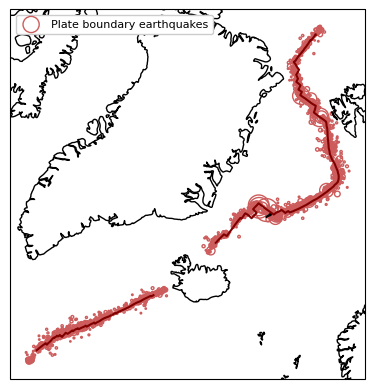

In [22]:
ax = MAR.plot()
ax.scatter(
    x=earthquakes.catalog.lon,
    y=earthquakes.catalog.lat,
    transform=ccrs.PlateCarree(),
    facecolors='none',
    edgecolors="indianred",
    s=np.exp(2*(earthquakes.catalog.mag-earthquakes.mag_completeness)),
    label="Plate boundary earthquakes",
)
legend = ax.legend()
legend.get_frame().set_alpha(1)

## Posistive statistics

In [23]:
evaluation_times, a_positive = PositiveStat(
    earthquakes.catalog.time.values, 
    earthquakes.catalog.mag.values,
).get_a(N=5,filter='median')

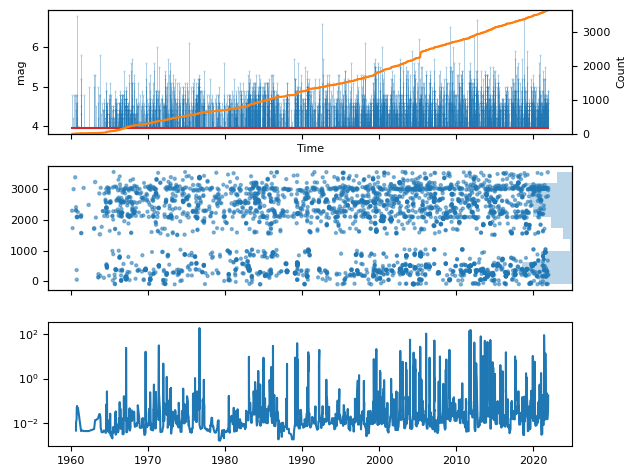

In [24]:
fig, ax = plt.subplots(3,1, sharex=True)
earthquakes.plot_time_series(ax=ax[0])
earthquakes.plot_space_time_series(
    p1=MAR.geometries.get_coordinates().values[0],
    p2=MAR.geometries.get_coordinates().values[-1],
    ax=ax[1]
)

ax[2].plot(evaluation_times, a_positive)
ax[2].set(yscale='log')
plt.tight_layout()


This I added quickly to calculate the monthly changes in a+. It occurs to me that perhaps we should be filtering these results according to whether they respond in extension or contraction.

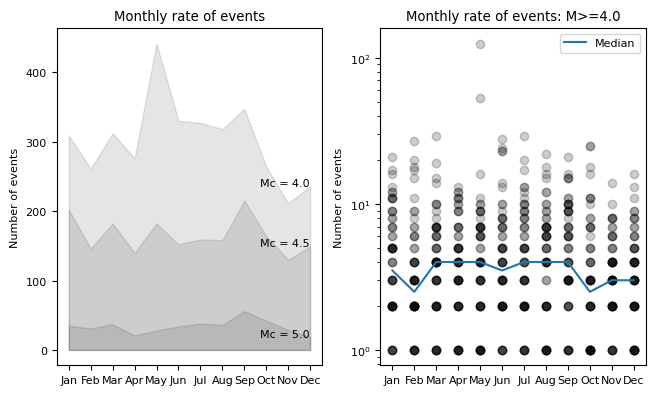

In [25]:
# Check whether there is any monthly modulation in the number of events in the catalog
def monthly_rate(df):
    
    df = df.copy()
    df["month"] = df.time.dt.month
    monthly_df = df.groupby("month").count()["time"]
    
    monthly_count = np.zeros(12)
    monthly_count[monthly_df.index.values-1] = monthly_df.values
    
    
    return np.arange(1,13), monthly_count

def plot_monthly_rate(df,fill=True, ax=None):
    """Using the time column of a catalog, plots the monthly rate of events."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,3))
    
    index, monthly_count = monthly_rate(df)
    
    # plot monthly rate with shaded area above zero
    if fill:
        ax.fill_between(index, monthly_count, 0, alpha=0.1, color="k")
    
    
    
    # text that with horizonatal alignment to the right
    ax.text(index.max(), monthly_count[-1], f"Mc = {mc:.1f}", ha="right")
    ax.set(
        xticks=np.arange(1,13),
        xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
        title="Monthly rate of events",
        ylabel="Number of events",
    )

    return ax

fig, ax = plt.subplots(1,2,figsize=(6.6,4))

for mc in np.arange(earthquakes.mag_completeness, 5.5, 0.5):
    plot_monthly_rate(earthquakes.catalog[earthquakes.catalog.mag >= mc], ax = ax[0])

monthly_count_array = []
for year in earthquakes.catalog.time.dt.year.unique():
    index,monthly_count = monthly_rate(earthquakes.catalog[earthquakes.catalog.time.dt.year == year])
    ax[1].scatter(index, monthly_count,c='k',alpha=0.2)
    monthly_count_array.append(monthly_count)

ax[1].plot(index,np.median(np.row_stack(monthly_count_array),axis=0),label='Median')
    
ax[1].set(
    xticks=np.arange(1,13),
    xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    title=f"Monthly rate of events: M>={earthquakes.mag_completeness}",
    ylabel="Number of events",
    yscale='log',
)
plt.legend()
plt.tight_layout()    

**Figure**: Seasonal variations in seismicity along the North Atlantic spreading ridge. Each line represent on threshold level for the catalog completeness. It may be interesting to see whether there appears to any phase correlation between the seismicity and the seasonal loading of the ice sheet. Note that this plot seems quite sensitive to declustering and varies for each random decluster.

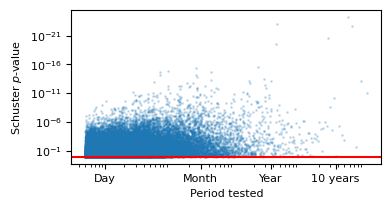

In [26]:
stat = Schuster(earthquakes.catalog.time.values[earthquakes.catalog.mag.values>4.2])
fig, ax = plt.subplots(figsize=(4,2))
dt = 0.5
ax = stat.spectrum(periods=1/np.arange(2/stat.duration, 1/dt,  dt/stat.duration), ax=ax)
ax.set(
    xticks = [1,30,365,365*10],
    xticklabels= ["Day", "Month", "Year", "10 years"],
);

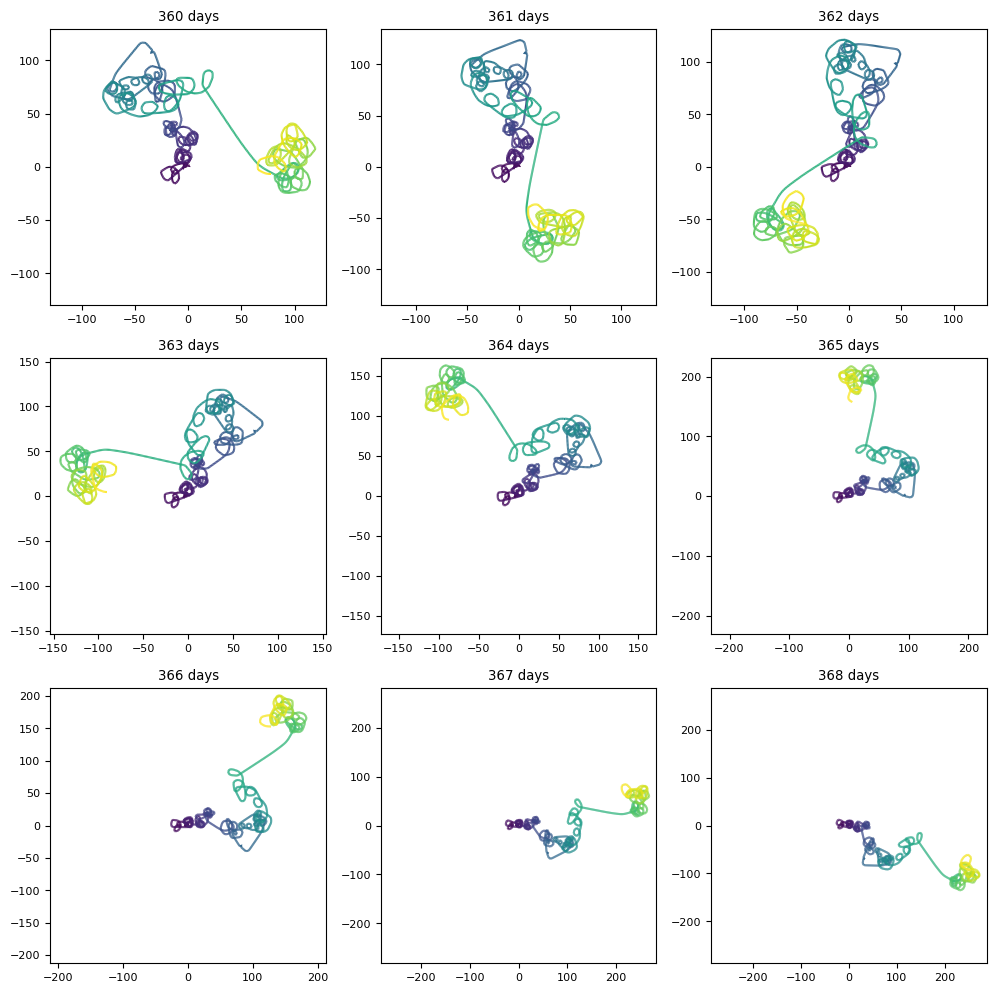

In [27]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
for n in range(9):
    stat.plot_walk(360+n, ax=ax.ravel()[n])
    ax.ravel()[n].set_title(f"{360+n} days")
plt.tight_layout()

## Along strike variations

/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


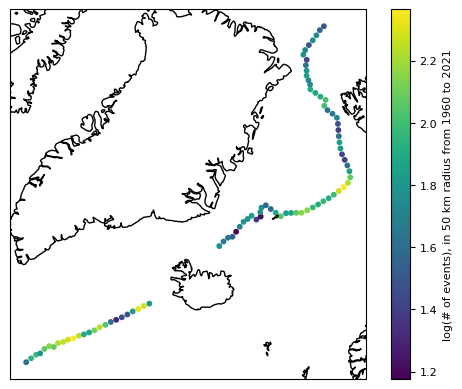

In [28]:
RADIUS = 50  # km
indices = earthquakes.get_intersecting_indices(
    [MAR.merged_geometry_meters.xy[1], MAR.merged_geometry_meters.xy[0]], buffer_radius_km=RADIUS
)
rate = [len(i) for i in indices]

ax = MAR.plot_basemap()

bdr = ax.scatter(
    MAR.merged_geometry_meters.xy[0], MAR.merged_geometry_meters.xy[1], c=np.log10(rate), s=10, transform=ccrs.PlateCarree()
)

plt.colorbar(
    bdr,
    label=f"log(# of events), in {RADIUS} km radius from {earthquakes.catalog.time.min().year} to {earthquakes.catalog.time.max().year}",
)

**Figure**: Along strike variatiosn in the rate of seismicity along the Mid Atlantic Ridge. Note that the colorbar is log-scaled. In red is an example of the earthquakes within the specified search radius. 


## Variations in time and space:

365 days 05:20:00


Text(0.5, 0, 'Rate')

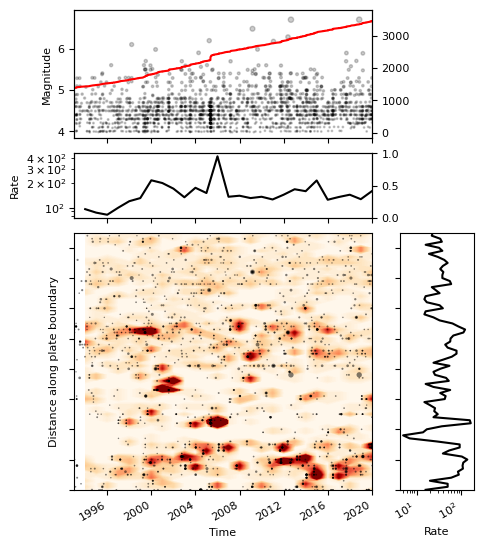

In [29]:
catalog = earthquakes.catalog

rate_grid = []
b_time = []
all_indices = []

delta_t = date_range[1] - date_range[0]
print(delta_t)

# Space-time rate:
for t1, t2 in zip(date_range[:-1], date_range[1:]):
    sub_catalog = catalog[(catalog.time < t2) & (catalog.time > t1)]
    indices = get_geometry_neighbors(
        sub_catalog,
        MAR.merged_geometry_meters,
        fun=radius_search,
        kwarg={"radius":  plate_boundary_metadata["stepsize"]/1e3},
    )
    all_indices.append(indices)
    rate_grid.append([len(i) for i in indices])

rate_grid = np.array(rate_grid).T

# Begin the plotting
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(
    3,
    2,
    width_ratios=(4, 1),
    height_ratios=(2, 1, 4),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.15,
    hspace=0.1,
)

ax = fig.add_subplot(gs[2, 0])
ax_seis = fig.add_subplot(gs[0, 0], sharex=ax)
ax_x = fig.add_subplot(gs[1, 0], sharex=ax)
ax_y = fig.add_subplot(gs[2, 1], sharey=ax)

# plot the earthquake catalog
ax_seis.scatter(
    catalog.time.to_numpy(),
    jitter(catalog.mag.to_numpy(), 0.01),
    s=np.exp(
        (
            catalog.mag.to_numpy()
            - earthquakes.mag_completeness
        )
    ),
    c="k",
    alpha=0.2,
    edgecolors=None,
)

ax_seis.set_ylabel("Magnitude")

ax_seis_b = ax_seis.twinx()
ax_seis_b.plot(
    catalog.time.to_numpy(),
    np.arange(len(catalog.time.to_numpy())),
    c="r",
)
ax_seis.set_xlim([date_range[0], date_range[-1]])

# plot the rate_grid of events over time
ax_x.plot(date_range[1:], rate_grid.sum(axis=0), c="k")
ax_x.set_yscale("log")
ax_x.set_ylabel("Rate")
ax_x_b = ax_x.twinx()

# plot the rate_grid of events over time and space
max_level = 0.1* rate_grid.max()
levels = np.linspace(rate_grid.min(), max_level, 100)
cf = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1e3,
    rate_grid,
    levels=levels,
    cmap="OrRd",
    vmax=max_level,
    extend="max",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
)

ax.scatter(
    catalog.time, catalog.distance_along_boundary/1000,
    color='black',
    s=np.exp(
        (
            (catalog.mag.to_numpy()
            - earthquakes.mag_completeness)
        )
    ),
    lw=0,
    alpha=0.5, 
)


ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")
ax.margins(x=0)
plt.gcf().autofmt_xdate()

# plot the rate of events over space
ax_y.plot(rate_grid.sum(axis=1), np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1000, c="k")
ax_y.set_yticklabels([])
ax_y.set_xscale("log")
ax_y.set_xlabel("Rate")


# Greenland Icesheet Glacial Isostatic Ajustment model output

We can next consider how these rates of seismicity relate to changes in Iceshelf loading over time.

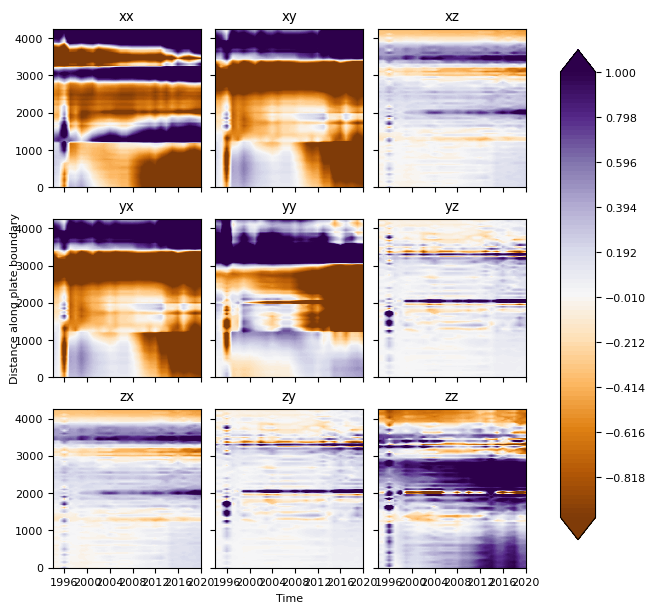

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)

xyz = ["x", "y", "z"]

im = [
    ax[i, j].contourf(
        date_range[1:],
        np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1000,
        strain_at_plate_boundary_grid[:, :, i, j],
        cmap="PuOr",
        levels=np.linspace(-1, 1, 100),
        extend="both",
        extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    )
    for i in range(3)
    for j in range(3)
][0]

[ax[i, j].set_title(f"{xyz[i]}{xyz[j]}") for i in range(3) for j in range(3)]

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
plt.xlabel("Time")
plt.ylabel("Distance along plate boundary")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(wspace=0.1, hspace=0.2)


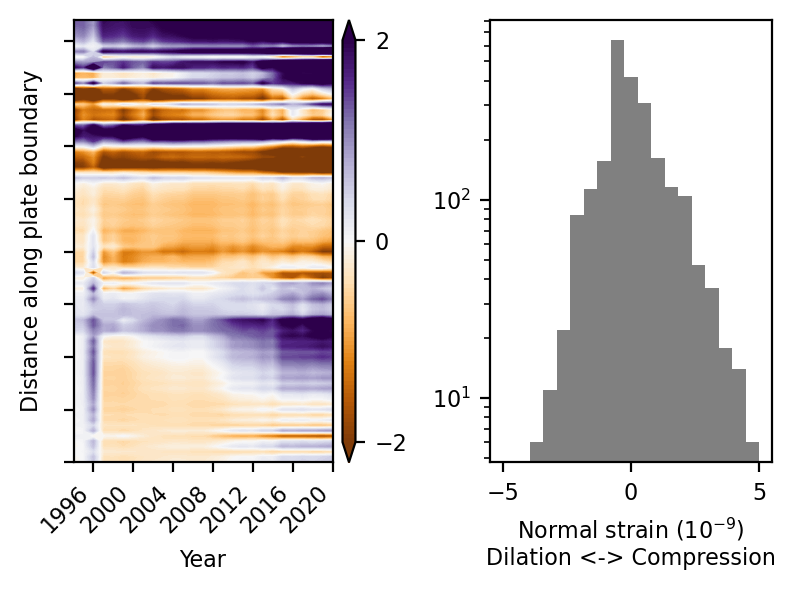

In [31]:

color_range = [-2, 2]
fig, AX = plt.subplots(1, 2, dpi=200, figsize=(4, 3))

ax = AX[0]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid) - 1) * plate_boundary_metadata["stepsize"]/1000,
    normal_strain_grid,
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")
for label in ax.get_xticklabels(which="major"):
    label.set(rotation=45, horizontalalignment="right")


ax.set_ylabel("Distance along plate boundary")
ax.set_yticklabels([])

ax = AX[1]
ax.hist(
    normal_strain_grid[:-1, :].flatten(),
    bins=np.linspace(-5, 5, 20),
    log=True,
    color="grey",
)
ax.set_xlabel("Normal strain $(10^{-9}$)\nDilation <-> Compression")

plt.tight_layout()


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_99816/1936188278.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('seismic'))


[Text(0, 0.5, 'Number of earthquakes')]

/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/kdascher/miniforge3/envs/grGIS_seismicity/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


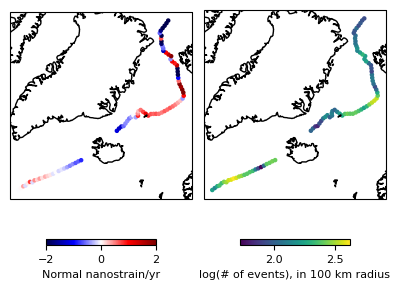

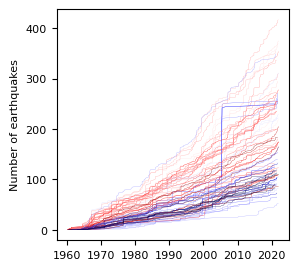

In [32]:
#Plot in map view with points colored as mean normal strain (calculated above)

crs = ccrs.NorthPolarStereo()
fig, AX = plt.subplots(1,2,subplot_kw=dict(projection=crs), figsize=(4, 3))

ax=AX[0]
color_range = [-2, 2]
bdr = ax.scatter(
    MAR.merged_geometry_meters.xy[0][:-1], MAR.merged_geometry_meters.xy[1][:-1], c=-np.mean(normal_strain_grid, axis=1), s=5, 
    transform=ccrs.PlateCarree(), cmap="seismic", vmin=-2, vmax=2)
ax.coastlines()
# ax.set_facecolor('lightgrey')

plt.colorbar(bdr, 
    label=f"Normal nanostrain/yr",
    location='bottom',
    shrink=0.6,
)

ax = AX[1]
RADIUS = 100  # km
indices = get_geometry_neighbors(
    catalog, MAR.merged_geometry_meters, fun=radius_search, kwarg={"radius": RADIUS}
)
rate = [len(i) for i in indices]

bdr = ax.scatter(
    *MAR.merged_geometry_meters.xy, c=np.log10(rate), s=5, transform=ccrs.PlateCarree()
)
ax.coastlines()
plt.colorbar(
    bdr,
    label=f"log(# of events), in {RADIUS} km radius",
    location='bottom',
    shrink=0.6,
)




RADIUS = 100  # km
indices = get_geometry_neighbors(
    catalog, MAR.merged_geometry_meters, fun=radius_search, kwarg={"radius": RADIUS}
)

norm = mpl.colors.Normalize(vmin=-2, vmax=2)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('seismic'))
cmap.set_array([])

plt.tight_layout()

fig, ax = plt.subplots(figsize=(3,3))
for i, zone in enumerate(indices[:-1]):
    color_value = -np.mean(normal_strain_grid, axis=1)[i]
    rgb = [1-(2+color_value)/4, 0, (2+color_value)/4]
    ax.plot(np.sort(catalog.time.values[zone]), np.arange(len(zone)), lw=0.2, c=cmap.to_rgba(color_value))

ax.set(
    ylabel='Number of earthquakes',
)


Figure: Spatial variations in the normal strain assuming a vertical plate boundary.

Question: How does long term GIA play into this? Could that be the main driver of this correspondence? Alternatively, could there be some geological reason for the earthquakes rate to be low near iceland and higher as you move away?

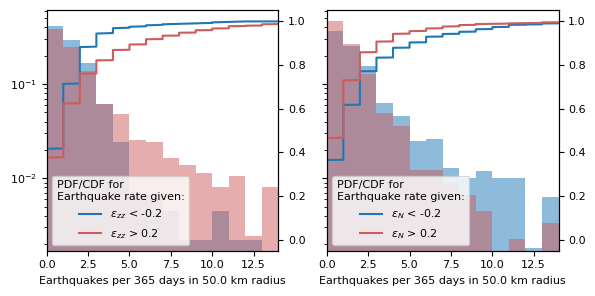

In [33]:
hist_kwargs = {"alpha": 0.5, "density": True}

xlabel = f"Earthquakes per {delta_t.days} days in {plate_boundary_metadata['stepsize']/1e3} km radius"
data_label = "Strain rate"


def plot_summary(
    x,
    y,
    y_threshold=0,
    ax=None,
    kwargs=hist_kwargs,
    xlabel=xlabel,
    base_label=data_label,
):
    bins = np.arange(
        *np.quantile(x, (0, 0.99)),
    )

    x2 = x[y > y_threshold]
    x1 = x[y < -y_threshold]

    if kwargs is None:
        kwargs = {}

    kwargs.update(
        {
            "bins": bins,
            "log": True,
            "density": True,
        }
    )

    ax.hist(x1, label=f"{base_label} < {-y_threshold}", **kwargs, color="C0")
    ax.hist(x2, label=f"{base_label} > {y_threshold}", **kwargs, color='indianred')

    axb = ax.twinx()
    axb.plot(
        np.sort(x1),
        np.linspace(0, 1, len(x1) + 1)[1:],
        label=f"{base_label} < {-y_threshold}",
        color="C0",
    )
    axb.plot(
        np.sort(x2),
        np.linspace(0, 1, len(x2) + 1)[1:],
        label=f"{base_label} > {y_threshold}",
        color='indianred',
    )
    axb.set_xlim(np.min(bins), np.max(bins))

    ax.set_xlabel(xlabel)

    lg = axb.legend()
    lg.set_title("PDF/CDF for\nEarthquake rate given:")


fig, AX = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax = AX[0]
ii = 2
plot_summary(
    rate_grid.flatten(),
    strain_at_plate_boundary_grid[:, :, ii, ii].flatten(),
    y_threshold=0.2,
    base_label=r"$\epsilon_{zz}$",
    ax=ax,
)

ax = AX[1]
plot_summary(
    rate_grid[:-1, :].flatten(),
    normal_strain_grid.flatten(),
    y_threshold=0.2,
    base_label=r"$\epsilon_{N}$",
    ax=ax,
)
plt.tight_layout()


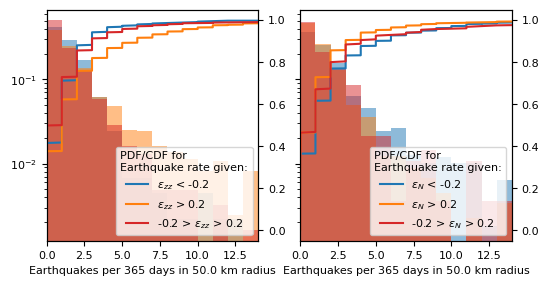

In [34]:
# Add third set of bins for values between the thresholds (around zero)

hist_kwargs = {"alpha": 0.5, "density": True}

xlabel = f"Earthquakes per {delta_t.days} days in {plate_boundary_metadata['stepsize']/1e3} km radius"
data_label = "Strain rate"


def plot_summary(
    x,
    y,
    y_threshold=0,
    ax=None,
    kwargs=hist_kwargs,
    xlabel=xlabel,
    base_label=data_label,
):
    bins = np.arange(
        *np.quantile(x, (0, 0.99)),
    )

    x2 = x[y > y_threshold]
    x1 = x[y < -y_threshold]
    x4 = x[y > -y_threshold]
    y4 = y[y > -y_threshold]
    x3 = x4[y4 < y_threshold]
    
#     x3 = x1[y1 <  y_threshold]
    
    if kwargs is None:
        kwargs = {}

    kwargs.update(
        {
            "bins": bins,
            "log": True,
            "density": True,
        }
    )

    ax.hist(x1, label=f"{base_label} < {-y_threshold}", **kwargs, color="C0")
    ax.hist(x2, label=f"{base_label} > {y_threshold}", **kwargs, color="C1")
    ax.hist(x3, label=f"{-y_threshold} > {base_label} > {y_threshold}", **kwargs, color="C3")

    axb = ax.twinx()
    axb.plot(
        np.sort(x1),
        np.linspace(0, 1, len(x1) + 1)[1:],
        label=f"{base_label} < {-y_threshold}",
        color="C0",
    )
    axb.plot(
        np.sort(x2),
        np.linspace(0, 1, len(x2) + 1)[1:],
        label=f"{base_label} > {y_threshold}",
        color="C1",
    )
    axb.plot(
        np.sort(x3),
        np.linspace(0, 1, len(x3) + 1)[1:],
        label=f"{-y_threshold} > {base_label} > {y_threshold}",
        color="C3",
    )
    axb.set_xlim(np.min(bins), np.max(bins))

    ax.set_xlabel(xlabel)

    lg = axb.legend()
    lg.set_title("PDF/CDF for\nEarthquake rate given:")


fig, AX = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax = AX[0]
ii = 2
plot_summary(
    rate_grid.flatten(),
    strain_at_plate_boundary_grid[:, :, ii, ii].flatten(),
    y_threshold=0.2,
    base_label=r"$\epsilon_{zz}$",
    ax=ax,
)

ax = AX[1]
plot_summary(
    rate_grid[:-1, :].flatten(),
    normal_strain_grid.flatten(),
    y_threshold=0.2,
    base_label=r"$\epsilon_{N}$",
    ax=ax,
)
# plt.tight_layout()

**Figure**: Comparison of the PDF for the rate of earthquake during periods with negative and positive vertical strain along the plate boundary. I find it diffucult to interpret a meaningful signal from this alone.

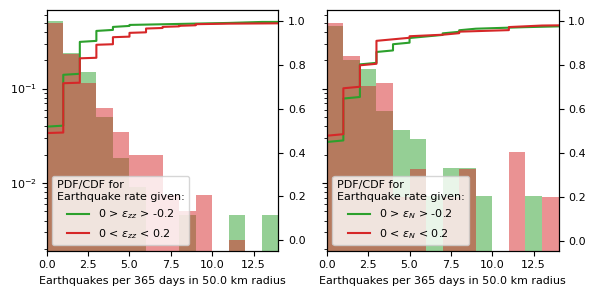

In [35]:
# Only bin values around zero
hist_kwargs = {"alpha": 0.5, "density": True}

xlabel = f"Earthquakes per {delta_t.days} days in {plate_boundary_metadata['stepsize']/1e3} km radius"
data_label = "Strain rate"


def plot_summary2(
    x,
    y,
    y_max_threshold=0.2,
    ax=None,
    kwargs=hist_kwargs,
    xlabel=xlabel,
    base_label=data_label,
):
    bins = np.arange(
        *np.quantile(x, (0, 0.99)),
    )

    x2 = x[0 < y]
    x1 = x[0 > y]
    y2 = y[0 < y]
    y1 = y[0 > y]
    
    x2=x2[y2 < y_max_threshold]
    x1=x1[y1 > -y_max_threshold]

    if kwargs is None:
        kwargs = {}

    kwargs.update(
        {
            "bins": bins,
            "log": True,
            "density": True,
        }
    )

    ax.hist(x1, label=f"{base_label} > {-y_max_threshold}", **kwargs, color=f"C2")
    ax.hist(x2, label=f"{base_label} < {y_max_threshold}", **kwargs, color=f"C3")

    axb = ax.twinx()
    axb.plot(
        np.sort(x1),
        np.linspace(0, 1, len(x1) + 1)[1:],
        label=f"0 > {base_label} > {-y_max_threshold}",
        color=f"C2",
    )
    axb.plot(
        np.sort(x2),
        np.linspace(0, 1, len(x2) + 1)[1:],
        label=f"0 < {base_label} < {y_max_threshold}",
        color=f"C3",
    )
    axb.set_xlim(np.min(bins), np.max(bins))

    ax.set_xlabel(xlabel)

    lg = axb.legend()
    lg.set_title("PDF/CDF for\nEarthquake rate given:")


fig, AX = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax = AX[0]
ii = 2
plot_summary2(
    rate_grid.flatten(),
    strain_at_plate_boundary_grid[:, :, ii, ii].flatten(),
    y_max_threshold=0.2,
    base_label=r"$\epsilon_{zz}$",
    ax=ax,
)

ax = AX[1]
plot_summary2(
    rate_grid[:-1, :].flatten(),
    normal_strain_grid.flatten(),
    y_max_threshold=0.2,
    base_label=r"$\epsilon_{N}$",
    ax=ax,
)
plt.tight_layout()


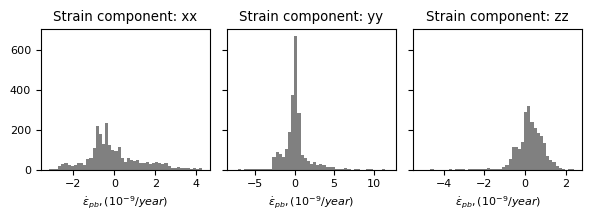

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 2.25), sharey=True)
for ii, iax in enumerate(ax):
    range_95th_percentile = np.percentile(
        strain_at_plate_boundary_grid[:, :, ii, ii].flatten(), [0.01, 99.99]
    )
    iax.hist(
        strain_at_plate_boundary_grid[:, :, ii, ii].flatten(),
        bins=np.linspace(*range_95th_percentile, 50),
        color="grey",
    )
    iax.set_xlabel(r"$\dot{\epsilon}_{pb}, (10^{-9}/year)$")
    iax.set_title(f"Strain component: {['xx','yy','zz'][ii]}")

plt.tight_layout()


**Figure**: GrGIA at the Atlantic mid ocean ridge.

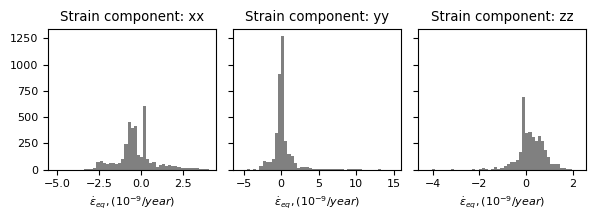

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 2.25), sharey=True)
for ii, iax in enumerate(ax):
    range_95th_percentile = np.percentile(
        strain_at_earthquake_with_time[:, ii, ii], [0.01, 99.99]
    )
    iax.hist(
        strain_at_earthquake_with_time[:, ii, ii],
        bins=np.linspace(*range_95th_percentile, 50),
        color="grey",
    )
    iax.set_xlabel(r"$\dot{\epsilon}_{eq}, (10^{-9}/year)$")
    iax.set_title(f"Strain component: {['xx','yy','zz'][ii]}")

plt.tight_layout()


**Figure**: GrGIA at earthquake locations

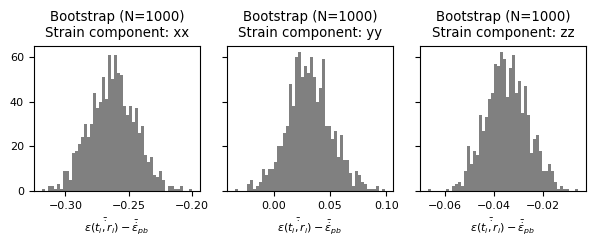

In [38]:
number_of_bootstrap_samples = 1000
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 2.5), sharey=True)

for ii, iax in enumerate(ax):
    mean_pb_strain = np.mean(strain_at_plate_boundary_grid[:, :, ii, ii].flatten())
    iax.hist(
        bootstrap_statistic(
            strain_at_earthquake_with_time[:, ii, ii] - mean_pb_strain,
            np.mean,
            boot=number_of_bootstrap_samples,
        ),
        bins=50,
        color="grey",
    )
    iax.set_xlabel(r"$\bar{\dot{\epsilon(t_i,r_i)}} - \bar{\dot{\epsilon}}_{pb}$")
    iax.set_title(
        f"Bootstrap (N={number_of_bootstrap_samples})\nStrain component: {['xx','yy','zz'][ii]}"
    )
plt.tight_layout()


**Figure**: Boostrap samples of the mean strain induced GrGIA at earthquake locations relative the plate boundary average. With reasonable statistical certainty, earthquakes tend to occur in areas/periods with higher strain. Correlation does not mean causation. This correspondance may instead result from the generally decreasing trend in seismicity towards the pole, which I interpret to be related to the decreasing spreading rate as the boudary approaches the Euler pole.

Text(0.5, 0, 'Latitude')

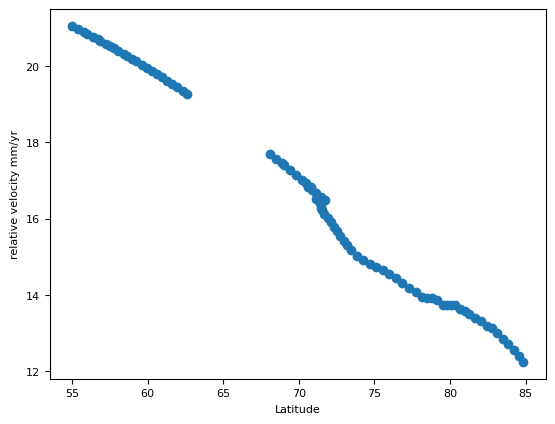

In [39]:
#Get plate rates to normalize eq rate by

NA_pole = [48.709, -78.167, 0.7486]  # deg/MA - DeMets et al. [1994]
EU_pole = [61.066, -85.819, 0.8591]  # deg/MA - DeMets et al. [1994]


def get_spreading_rate(
    lat: np.ndarray = None,
    lon: np.ndarray = None,
    pole1: list[float, float, float] = NA_pole,
    pole2: list[float, float, float] = EU_pole,
) -> np.ndarray:
    """Gets the relative plate rate at a plate boundary for each lat lon pair given two euler poles

    The `pole` contains the **** lon, lat **** and angular roation rate (assumed to be in deg/MA). 
    
    Note that a relatively exhaustive list of pole can be found in the following link:
    http://peterbird.name/oldFTP/PB2002/PB2002_poles.dat.txt

    Returns the spreading rate in km/Ma (or, equivalently mm/yr)

    """

    pole1, pole2, lat, lon = map(np.radians, [pole1, pole2, lat, lon])

    earth_radius_km = 6367
    locations = np.column_stack((lat, lon, np.ones_like(lat) * earth_radius_km))

    cartesian = lambda p: np.array(
        [
            p[:, 2] * np.cos(p[:, 0]) * np.cos(p[:, 1]),
            p[:, 2] * np.cos(p[:, 0]) * np.sin(p[:, 1]),
            p[:, 2] * np.sin(p[:, 0]),
        ]
    )
    omega1, omega2, r = map(
        cartesian, [np.expand_dims(pole1, 0), np.expand_dims(pole2, 0), locations]
    )

    omega = omega1 - omega2

    v = np.cross(omega.T, r.T)

    return np.sqrt(np.sum(v * v, 1))


plt.scatter(
    MAR.merged_geometry_meters.xy[1],
    get_spreading_rate(
        lat=MAR.merged_geometry_meters.xy[1], lon=MAR.merged_geometry_meters.xy[0]
    ),
)
plt.ylabel("relative velocity mm/yr")
plt.xlabel("Latitude")


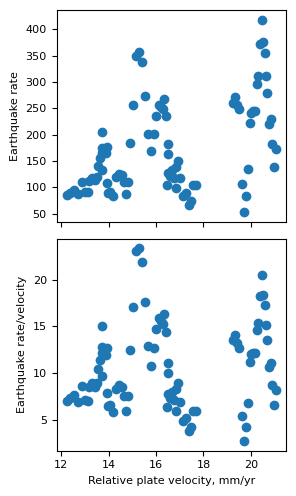

In [40]:
plate_boundary_velocity = get_spreading_rate(
    lat=MAR.merged_geometry_meters.xy[1], lon=MAR.merged_geometry_meters.xy[0]
)

fig, AX = plt.subplots(2, 1, figsize=(3, 5), sharex=True)

ax = AX[0]
ax.scatter(plate_boundary_velocity, rate)
ax.set_ylabel("Earthquake rate")

ax = AX[1]
ax.scatter(plate_boundary_velocity, rate / plate_boundary_velocity)
ax.set_xlabel("Relative plate velocity, mm/yr")
ax.set_ylabel("Earthquake rate/velocity")

plt.tight_layout()


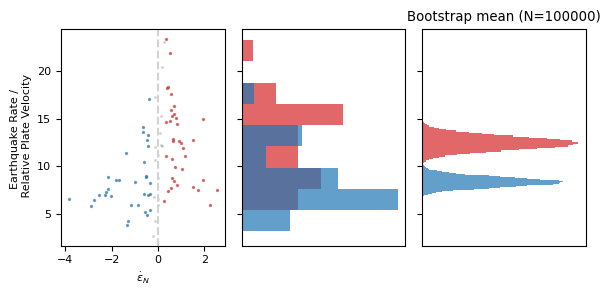

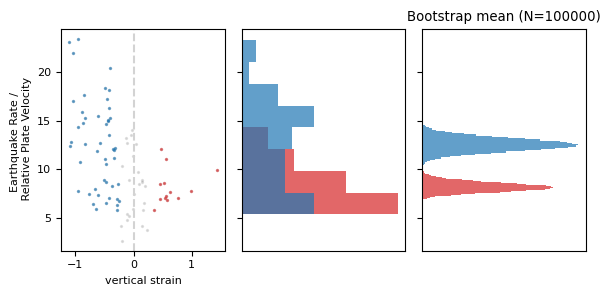

In [41]:
def summary_plot(x,y,theshold, data_label=None):
    fig, AX = plt.subplots(1, 3, sharey=True, figsize=(6, 3))
    ax = AX[0]

    #Labels are flipped pos/neg to match convention since strain is *-1
    positive_index = x > theshold
    negative_index = x < -theshold
    ax.scatter(-x, y, s=2, alpha=0.1, c='k')
    ax.scatter(-x[negative_index], y[negative_index], s=2, alpha=0.5,color='C3')
    ax.scatter(-x[positive_index], y[positive_index], s=2, alpha=0.5)
    ax.set_xlabel(f"{data_label}")
    ax.set_ylabel("Earthquake Rate / \n Relative Plate Velocity")
    ax.axvline(0, c="lightgrey", ls="--")

    ax = AX[1]
    range_95th_percentile = np.percentile(y, [0.5, 99.5])
    bins = np.linspace(*range_95th_percentile, 10)
    ax.hist(
        y[negative_index],
        bins=bins,
        orientation="horizontal",
        alpha=0.7,
        label="strain<{theshold}".format(theshold=-theshold),
        density=True,
        color='C3'
    )
    ax.hist(
        y[positive_index],
        bins=bins,
        orientation="horizontal",
        alpha=0.7,
        label="strain>{theshold}".format(theshold=theshold),
        density=True,
    )

    ax.set(
        xticks=[],
    )

    ax = AX[2]
    number_of_bootstrap_samples = 100000
    [ax.hist(
        bootstrap_statistic(
            y[i],
            np.mean,
            boot=number_of_bootstrap_samples,
        ),
        orientation="horizontal",
        alpha=0.7,
        bins=50,
        color='C3'
    ) for i in [negative_index]
    ]

    [ax.hist(
        bootstrap_statistic(
            y[i],
            np.mean,
            boot=number_of_bootstrap_samples,
        ),
        orientation="horizontal",
        alpha=0.7,
        bins=50,
        color='C0'
    ) for i in [positive_index]
    ]
    
    ax.set(
        xticks=[],
        title="Bootstrap mean (N={number_of_bootstrap_samples})".format(
            number_of_bootstrap_samples=number_of_bootstrap_samples
        ),
    )

    plt.tight_layout()

summary_plot(np.mean(normal_strain_grid, axis=1), (rate / plate_boundary_velocity)[1:], 0.25, data_label = r"$\dot{\epsilon}_N$")
summary_plot(np.mean(strain_at_plate_boundary_grid[:, :, 2, 2][1:], axis=1), (rate / plate_boundary_velocity)[1:], 0.25, data_label = "vertical strain")


**Figure**: Time averaged strain rate versus the normalized rate of seismicity. It does seem that, in agreement with expectation, the rate of seismicity tends to be higher in areas more GrGIA dilation (blue).

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_99816/192963950.py:2: RuntimeWarning: divide by zero encountered in log10
  log_normalized_rate_grid = np.log10((rate_grid / velocity_grid)[1:, :])


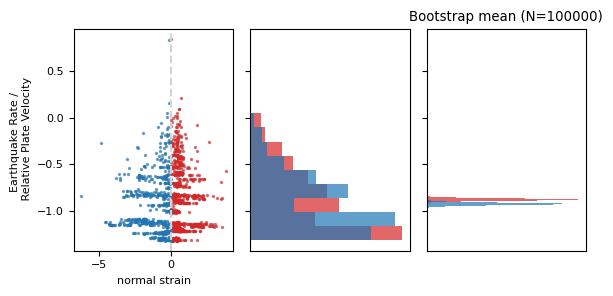

In [42]:
velocity_grid = np.expand_dims(plate_boundary_velocity, 1) * np.ones_like(gia.time)
log_normalized_rate_grid = np.log10((rate_grid / velocity_grid)[1:, :])

not_zero = ((rate_grid / velocity_grid)[1:, :]) > 0
summary_plot(normal_strain_grid[not_zero], log_normalized_rate_grid[not_zero], 0, data_label = "normal strain")

Figure: Here we just consider every single point on the MAR for every time step. The increased number points does increase the statistical significance. However, note that these so-called measurements are strongly correlated in space and time. I think we also need to be cautious about this more generally when using the bootstrap estimates. NOTE the y-axis is log-scaled. 

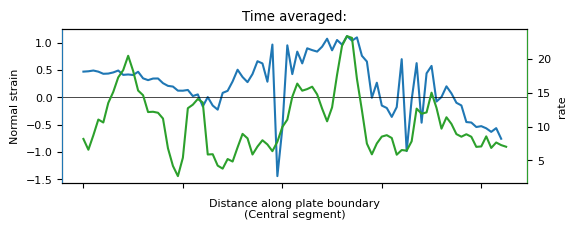

In [43]:
fig, ax = plt.subplots(figsize=(6, 2))

ax.plot(strain_at_plate_boundary_grid[:, :, 2, 2].mean(axis=1)[1:])
ax.axhline(0, c="k", lw=0.5)


axc = ax.twinx()
axc.plot(rate / plate_boundary_velocity, c="C2")
axc.spines["right"].set_edgecolor("C2")
axc.spines["left"].set_edgecolor("C0")
axc.set_ylabel("rate")


ax.set(
    title="Time averaged:",
    xticklabels=[],
    xlabel="Distance along plate boundary\n(Central segment)",
    ylabel = "Normal strain",
);


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_99816/2222861884.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  [iax.set_xticklabels(iax.get_xticklabels(), rotation = 45, ha="right") for iax in AX]


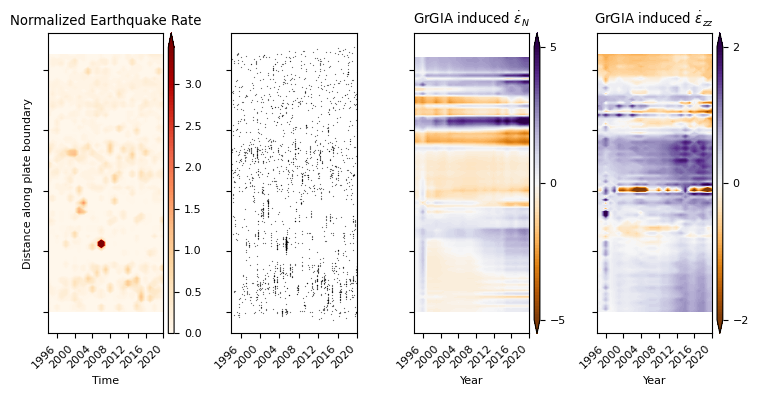

In [44]:
fig, AX = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(7.5, 4))
    
ax = AX[0]
# plot the rate_grid of events over time and space
max_level = 0.5 * (rate_grid / velocity_grid).max()
levels = np.linspace((rate_grid / velocity_grid).min(), max_level, 100)
cf = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1000,
    rate_grid / velocity_grid,
    levels=levels,
    cmap="OrRd",
    vmax=max_level,
    extend="max",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
)
x_lim = ax.get_xlim()

ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")
ax.margins(x=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax, ticks=np.arange(0, max_level, 0.5))

ax.set_title("Normalized Earthquake Rate")


ax = AX[1]
ax.scatter(
    catalog.time, catalog.distance_along_boundary/1000 + np.random.normal(0, 50, len(catalog)),
    color='black',
    s=0.5,
    lw=0.2,
    alpha=0.5, 
)


ax = AX[1+1]
color_range = [-5, 5]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid) - 1) * plate_boundary_metadata["stepsize"]/1000,
    normal_strain_grid,
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")


ax.set_yticklabels([])
ax.set_title(r"GrGIA induced $\dot{\epsilon}_N$")

ax = AX[2+1]
color_range = [-2, 2]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * plate_boundary_metadata["stepsize"]/1000,
    strain_at_plate_boundary_grid[:, :, 2, 2],
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")


ax.set_yticklabels([])

ax.set_title(r"GrGIA induced $\dot{\epsilon}_{zz}$")

[iax.set(xlim=x_lim) for iax in AX]
[iax.set_xticklabels(iax.get_xticklabels(), rotation = 45, ha="right") for iax in AX]

plt.tight_layout()


In [45]:
NUMBER_OF_EVENTS = 200
WINDOW_SIZE = 100
tshift = 1
date_range2 = pd.date_range(
    start=datetime.datetime(GrGIA_strain_metadata["data_config"]["starttime"] - tshift, 1, 1),
    end=datetime.datetime(GrGIA_strain_metadata["data_config"]["endtime"] + tshift, 1, 1),
    periods=28+2*tshift,
)
delta_t2 = date_range2[1] - date_range2[0]
print(delta_t2)


# get the indices of the k nearest neighbors to each point in the boundary
indices = get_geometry_neighbors(
    catalog, MAR.merged_geometry_meters, fun=k_nearest_search, kwarg={"k": NUMBER_OF_EVENTS}
)

rate_grid2 = []
# Space-time rate:
for t1, t2 in zip(date_range2[:-1], date_range2[1:]):
    sub_catalog = catalog[(catalog.time < t2) & (catalog.time > t1)]
    indices = get_geometry_neighbors(
        sub_catalog,
        MAR.merged_geometry_meters,
        fun=radius_search,
        kwarg={"radius": WINDOW_SIZE},
    )
    all_indices.append(indices)
    rate_grid2.append([len(i) for i in indices])

rate_grid2 = np.array(rate_grid2).T

365 days 06:37:14.482758620


Text(0.5, 0, 'Year')

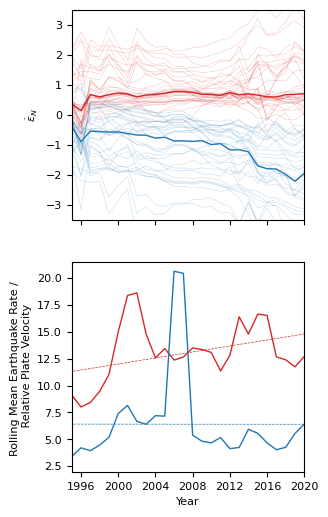

In [46]:

fig, ax = plt.subplots(2,1,figsize=(3,6), sharex=True)

ns_val = 0.25
ns_df = pd.DataFrame(normal_strain_grid)
ns_df.columns = date_range[1:]
pos_ns_df = ns_df.loc[ns_df.mean(axis=1) > ns_val]
neg_ns_df = ns_df.loc[ns_df.mean(axis=1) < -ns_val]
ax[0].set_xlim([datetime.datetime(1995,1,1),datetime.datetime(2020,1,1)])

#Flip positive and negative for plotting to match convention
ax[0].plot(-neg_ns_df.T,lw=0.5,color='C3',alpha=0.2)
ax[0].plot(-neg_ns_df.median(),lw=1,color='C3')
ax[0].plot(-pos_ns_df.T,lw=0.5,color='C0',alpha=0.2)
ax[0].plot(-pos_ns_df.median(),lw=1,color='C0')
ax[0].set_ylim([-3.5, 3.5])
ax[0].set_ylabel(r"$\dot{\epsilon}_N$")



rate_df = pd.DataFrame(rate_grid2[:, :], columns=date_range2[1:])
pv_df = pd.DataFrame(plate_boundary_velocity, index=rate_df.index)
norm_rate_df = rate_df.div(pv_df.values, axis=0)
norm_rate_df = norm_rate_df[:-1]

#Calc Rolling Mean
pos_rate_df = norm_rate_df.loc[ns_df.mean(axis=1) > ns_val]
pos_rate_df_rm = pos_rate_df.sum().rolling(2*tshift, center=True).mean().iloc[tshift:-tshift]
neg_rate_df = norm_rate_df.loc[ns_df.mean(axis=1) < ns_val]
neg_rate_df_rm = neg_rate_df.sum().rolling(2*tshift, center=True).mean().iloc[tshift:-tshift]

#Calc Linear fit
px, py  =np.arange(len(pos_rate_df_rm)), pos_rate_df_rm.values
pos_p = np.poly1d(np.polyfit(px, py, 1))
nx, ny  =np.arange(len(neg_rate_df_rm)), neg_rate_df_rm.values
neg_p = np.poly1d(np.polyfit(nx, ny, 1))

#Plot EQs
ax[1].plot(neg_rate_df_rm,lw=1,color='C3')
ax[1].plot(neg_rate_df_rm.index, neg_p(nx), color='C3', ls='--', lw=0.5)
ax[1].plot(pos_rate_df_rm,lw=1,color='C0')
ax[1].plot(pos_rate_df_rm.index, pos_p(px), color='C0', ls='--', lw=0.5)


ax[1].set_ylabel("Rolling Mean Earthquake Rate / \n Relative Plate Velocity")
ax[1].set_xlabel("Year")

# ax[2].plot((-neg_ns_df.median())- (-pos_ns_df.median()),c='orange', label='Strain difference')
# ax2b = ax[2].twinx()
# ax2b.plot(neg_rate_df_rm.index, neg_rate_df_rm-pos_rate_df_rm,c='k', label='Eq. rate difference')



In [47]:
neg_x

NameError: name 'neg_x' is not defined

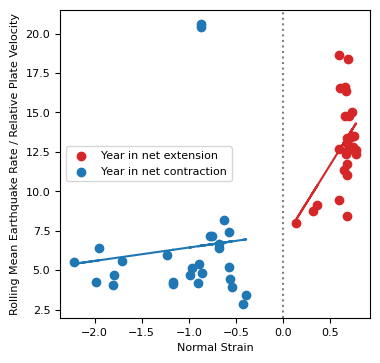

In [ ]:
fig, ax = plt.subplots(1,1,sharex=True,figsize=(4,4))

# Again, neg is now pos... 
neg_x0, neg_y0 = -neg_ns_df.median().values, neg_rate_df.sum().iloc[tshift:-tshift].values
pos_x0, pos_y0 = -pos_ns_df.median().values, pos_rate_df.sum().iloc[tshift:-tshift].values
neg_x, neg_y = -neg_ns_df.median().values, neg_rate_df_rm.values
pos_x, pos_y = -pos_ns_df.median().values, pos_rate_df_rm.values
x = np.append(neg_x, pos_x)
x.sort()

ax.scatter(neg_x, neg_y, color='C3',label="Year in net extension")
neg_p = np.poly1d(np.polyfit(neg_x, neg_y, 1))
ax.plot(neg_x, neg_p(neg_x), color='C3')

ax.scatter(pos_x, pos_y, color='C0',label="Year in net contraction")
pos_p = np.poly1d(np.polyfit(pos_x, pos_y, 1))
ax.plot(pos_x, pos_p(pos_x), color='C0')


ax.axvline(0, color='grey', ls=':')
ax.set_ylabel("Rolling Mean Earthquake Rate / Relative Plate Velocity")
ax.set_xlabel("Normal Strain")
ax.legend()

I worry that the temporal trend is dubious. Here it kind of looks like the outlier is dragging the fit upwards. Were it not for the outlier it kind of looks like a negative slope. 